In [2]:
from manifold_learning.data.data_loader import load_csv_dataset, load_ld2011_2014_dataset, load_traffic_dataset
from manifold_learning import IMD
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy import io
importlib.reload(IMD)

<module 'manifold_learning.IMD' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/IMD.py'>

In [15]:
io.loadmat("../src/manifold_learning/data/datasets/dataVKDecay2DGalphaStatic.mat")["xData"][1][1].shape

(2640, 20102)

In [17]:
20102

20102

In [2]:
import torch
torch.cuda.empty_cache()

In [34]:
X = load_csv_dataset("Jan1023_1_fr_ma2sec_sr30.csv").to_numpy()[:,1:]

In [38]:
X = load_ld2011_2014_dataset().to_numpy()[:,1:].astype(np.float32)

In [2]:
X = load_traffic_dataset()
X = X.to_numpy()[:,1:].astype(np.float32).T
X[np.isnan(X)] = 0
X = np.log(X+1)
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)

In [144]:
X = load_traffic_dataset()
X = X[X.columns[1:]]

df = X.T

# Interpolate missing values
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Fill any remaining missing values with zeros
df_filled = df_interpolated.fillna(0)
X = df_filled.to_numpy().astype(np.float32)


X = np.log(X+1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)


#pca = PCA(803,whiten=True)
#X = pca.fit_transform(X)

In [111]:
X = np.concatenate([X[3:],X[2:-1],X[1:-2],X[:-3]],axis=1)

In [148]:
trainer = IMD.IMD_nD(X.shape[1], embed_dim=12, n_components=15,subtract_corr=False, learning_rate=0.001, device="cuda",optimizer="Adam")

In [149]:
trainer.fit(X, sample_len=140, library_len=400, exclusion_rad=20, nbrs_num=20, tp=30, epochs=1000, num_batches=32)


Epoch 1/1000, Loss: 1.0434
Epoch 2/1000, Loss: 0.7321
Epoch 3/1000, Loss: 0.6794
Epoch 4/1000, Loss: 0.6514
Epoch 5/1000, Loss: 0.6320
Epoch 6/1000, Loss: 0.6191
Epoch 7/1000, Loss: 0.6090
Epoch 8/1000, Loss: 0.5995
Epoch 9/1000, Loss: 0.5920
Epoch 10/1000, Loss: 0.5846
Epoch 11/1000, Loss: 0.5766
Epoch 12/1000, Loss: 0.5733
Epoch 13/1000, Loss: 0.5695
Epoch 14/1000, Loss: 0.5633
Epoch 15/1000, Loss: 0.5606
Epoch 16/1000, Loss: 0.5551
Epoch 17/1000, Loss: 0.5508
Epoch 18/1000, Loss: 0.5446
Epoch 19/1000, Loss: 0.5426
Epoch 20/1000, Loss: 0.5378
Epoch 21/1000, Loss: 0.5340
Epoch 22/1000, Loss: 0.5294
Epoch 23/1000, Loss: 0.5250
Epoch 24/1000, Loss: 0.5210
Epoch 25/1000, Loss: 0.5208
Epoch 26/1000, Loss: 0.5144
Epoch 27/1000, Loss: 0.5104
Epoch 28/1000, Loss: 0.5114
Epoch 29/1000, Loss: 0.5056
Epoch 30/1000, Loss: 0.5038
Epoch 31/1000, Loss: 0.4994
Epoch 32/1000, Loss: 0.4992
Epoch 33/1000, Loss: 0.4933
Epoch 34/1000, Loss: 0.4909
Epoch 35/1000, Loss: 0.4892
Epoch 36/1000, Loss: 0.4887
E

KeyboardInterrupt: 

In [31]:
torch.save(trainer.model.state_dict(), 'traffic_dataset_14_20_sl140_ll400_knn20_tp15.pth')

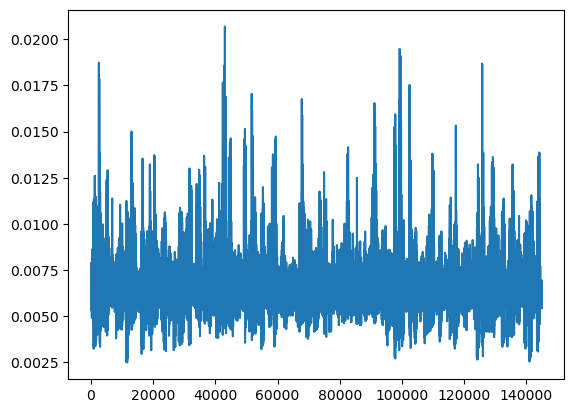

In [150]:
plt.plot(np.abs(trainer.model.get_weights()).mean(axis=(1,2)))

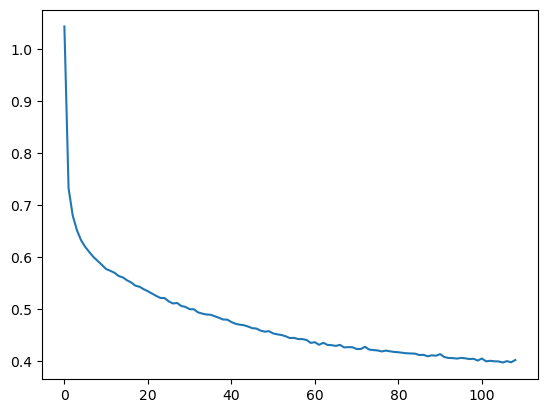

In [151]:
plt.plot(trainer.get_loss_history()[:])


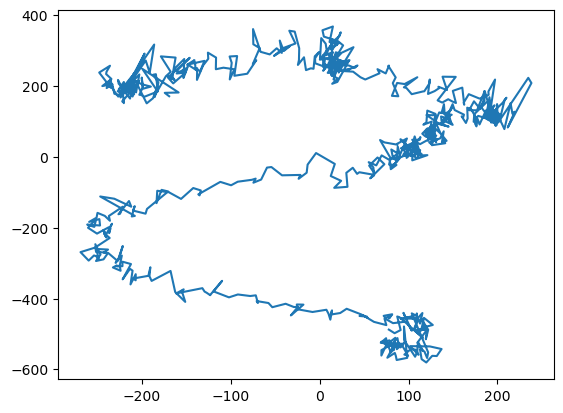

In [152]:
plt.plot(trainer.predict(X)[:,3,2],trainer.predict(X)[:,3,1])

In [153]:

unmixed = trainer.predict(X)

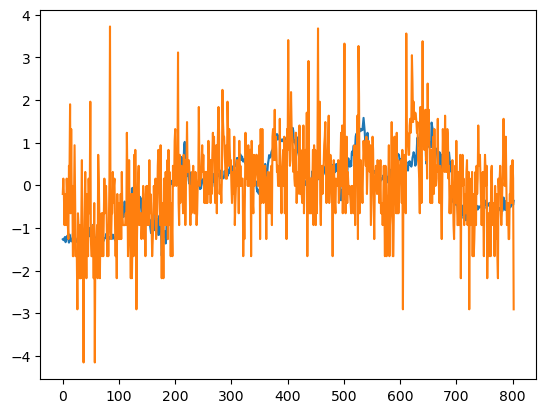

In [158]:
plt.plot(trainer.generate(X[:],20,20,1)[1][:,3333].cpu().detach().numpy())
plt.plot(X[:,3333])

In [1]:
X_pred = np.array([trainer.generate(X[:],20,20,i)[1].cpu().detach().numpy()[-100:] for i in range(1,75)])

NameError: name 'np' is not defined

In [ ]:
X_pred_aligned = np.array([np.concatenate([X_pred[i,73-i:],np.full((73-i,X_pred.shape[2]),np.nan)]) for i in range(74)])

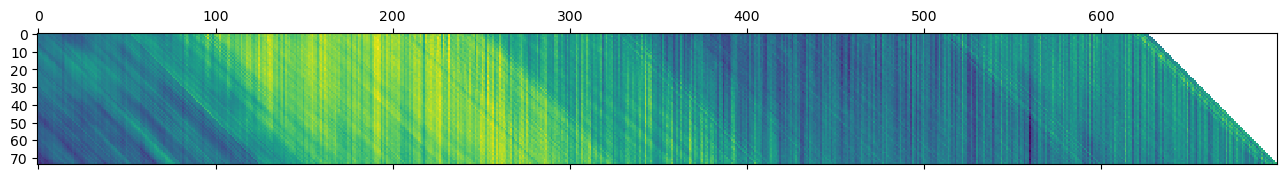

In [126]:
plt.matshow(X_pred_aligned[:,:,2])

In [127]:
X_ = np.nanmean(X_pred_aligned[:,-74:,:],axis=0)[:62]

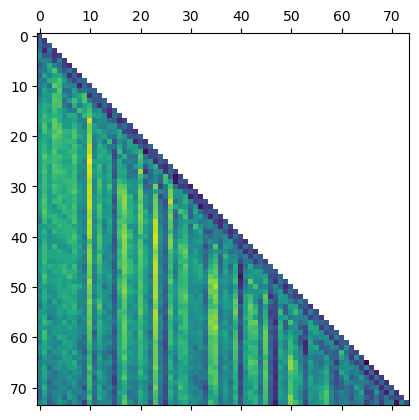

In [128]:
plt.matshow(X_pred_aligned[:,-74:,1])

In [130]:

X_ = pca.inverse_transform(X_[:,:803])

In [131]:
X_.shape

(62, 145035)

In [132]:
prediction = np.zeros((62,X_mean.shape[0]))
prediction[:,(X_mean != 0)] = X_[:]
prediction[:,(X_mean != 0)] = np.round(np.exp(((prediction[:,(X_mean != 0)]*X_std[(X_mean != 0)])+X_mean[(X_mean != 0)]))-1)

In [21]:
train_df = pd.read_csv("../src/manifold_learning/data/datasets/train_2.csv")
key_df = pd.read_csv("../src/manifold_learning/data/datasets/key_2.csv")

names = np.array([i[:-11] for i in key_df["Page"].to_numpy()])

sorted_indices = np.argsort(train_df["Page"].to_numpy())

# Create a sorted version of A
sorted_A = train_df["Page"].to_numpy()[sorted_indices]

# Use searchsorted to find the indices of B elements in the sorted A
order = sorted_indices[np.searchsorted(sorted_A, names[::62])]

(train_df["Page"][order].to_numpy() == names[::62]).sum()

145063

In [133]:
res = pd.read_csv("../src/manifold_learning/data/datasets/sample_submission_2.csv")
res["Visits"] = prediction[:,order].T.flatten().astype(int)

res.set_index("Id").to_csv("../src/manifold_learning/data/datasets/results_2.csv")

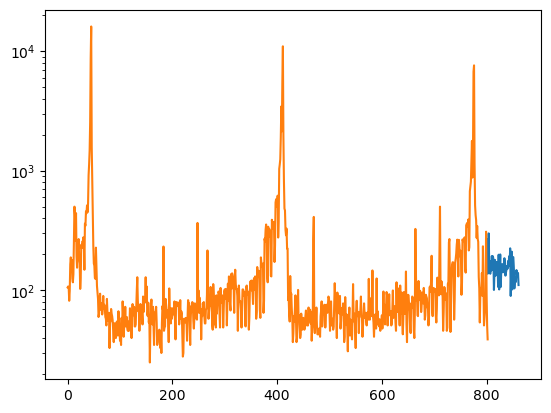

In [134]:
plt.plot(np.arange(X.shape[0],X.shape[0]+62),prediction[:,order[333]])
plt.plot(train_df.iloc[order[333]][1:].to_numpy())
#plt.xlim(600,920)
plt.yscale("log")

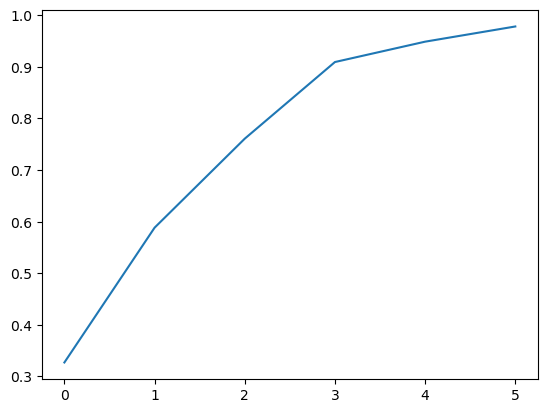

In [646]:

pca = PCA(6)
xxx = pca.fit_transform(unmixed[:,3])
plt.plot(np.cumsum(pca.explained_variance_ratio_))

ValueError: 'c' argument has 50 elements, which is inconsistent with 'x' and 'y' with size 650.

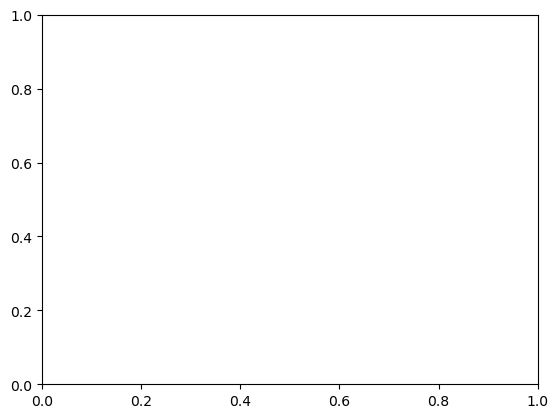

In [49]:
plt.scatter(xxx[:,0], xxx[:,1],c=np.arange(550))

In [647]:
import plotly.express as px
fig = px.line_3d(x=xxx[:,0], y=xxx[:,1],z=xxx[:,2],height=700)

fig.show()